In [3]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb

from baselines import bench
from baselines.common.atari_wrappers import make_atari, wrap_deepmind,LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

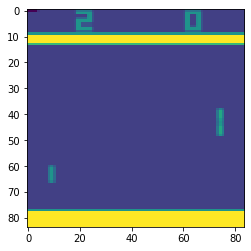

In [4]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

#plt.imshow(env.render("rgb_array"))
# env.close()

In [5]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)


In [6]:
class Memory_Buffer(object):
    def __init__(self, memory_size=1000):
        self.buffer = []
        self.memory_size = memory_size
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.size() - 1)
            data = self.buffer[idx]
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


In [7]:
class DQNAgent: 
    def __init__(self, in_channels = 1, action_space = [], USE_CUDA = False, memory_size = 10000, epsilon  = 1, lr = 1e-4):
        self.epsilon = epsilon
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer(memory_size)
        self.DQN = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target.load_state_dict(self.DQN.state_dict())


        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.RMSprop(self.DQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state, epsilon = None):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if epsilon is None: epsilon = self.epsilon

        q_values = self.value(state).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done).bool()  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma *next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((predicted_qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.memory_buffer.size() - 1)
            data = self.memory_buffer.buffer[idx]
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.DQN.parameters():
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [8]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99
epsilon_max = 1
epsilon_min = 0.01
eps_decay = 30000
frames = 2000000
USE_CUDA = True
learning_rate = 2e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 10000
win_reward = 18     # Pong-v4
win_break = True

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
agent = DQNAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "DQN_stackframe", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])

for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, epsilon)
    
    next_frame, reward, done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        loss = agent.learn_from_experience(batch_size)
        losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, epsilon: %5f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)
        
    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
    
    if done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()

F:\softwares\ANACONDA\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\softwares\ANACONDA\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frames:     0, reward:   nan, loss: 0.000000, epsilon: 1.000000, episode:    0
frames:  1000, reward: -21.000000, loss: 0.000000, epsilon: 0.967544, episode:    1
frames:  2000, reward: -21.000000, loss: 0.000000, epsilon: 0.936152, episode:    2
frames:  3000, reward: -20.666667, loss: 0.000000, epsilon: 0.905789, episode:    3
frames:  4000, reward: -20.500000, loss: 0.000000, epsilon: 0.876422, episode:    4
frames:  5000, reward: -20.600000, loss: 0.000000, epsilon: 0.848017, episode:    5
frames:  6000, reward: -20.666667, loss: 0.000000, epsilon: 0.820543, episode:    6
frames:  7000, reward: -20.714286, loss: 0.000000, epsilon: 0.793971, episode:    7
frames:  8000, reward: -20.750000, loss: 0.000000, epsilon: 0.768269, episode:    8
frames:  9000, reward: -20.666667, loss: 0.000000, epsilon: 0.743410, episode:    9
frames: 10000, reward: -20.700000, loss: 0.000681, epsilon: 0.719366, episode:   11
frames: 11000, reward: -20.700000, loss: 0.000297, epsilon: 0.696110, episode:   

frames: 98000, reward: -20.400000, loss: 0.002644, epsilon: 0.047752, episode:  109
frames: 99000, reward: -20.600000, loss: 0.001584, epsilon: 0.046514, episode:  111
frames: 100000, reward: -20.400000, loss: 0.001171, epsilon: 0.045317, episode:  112
frames: 101000, reward: -20.400000, loss: 0.001929, epsilon: 0.044159, episode:  113
frames: 102000, reward: -20.500000, loss: 0.004967, epsilon: 0.043040, episode:  114
frames: 103000, reward: -20.400000, loss: 0.001417, epsilon: 0.041956, episode:  115
frames: 104000, reward: -20.500000, loss: 0.007077, epsilon: 0.040909, episode:  116
frames: 105000, reward: -20.500000, loss: 0.001342, epsilon: 0.039895, episode:  117
frames: 106000, reward: -20.500000, loss: 0.002944, epsilon: 0.038915, episode:  118
frames: 107000, reward: -20.600000, loss: 0.022422, epsilon: 0.037967, episode:  119
frames: 108000, reward: -20.600000, loss: 0.002681, epsilon: 0.037050, episode:  119
frames: 109000, reward: -20.400000, loss: 0.002142, epsilon: 0.0361

frames: 195000, reward: -15.200000, loss: 0.002191, epsilon: 0.011488, episode:  163
frames: 196000, reward: -16.000000, loss: 0.002308, epsilon: 0.011440, episode:  164
frames: 197000, reward: -16.000000, loss: 0.012042, epsilon: 0.011392, episode:  164
frames: 198000, reward: -16.000000, loss: 0.001483, epsilon: 0.011347, episode:  164
frames: 199000, reward: -15.100000, loss: 0.002209, epsilon: 0.011303, episode:  165
frames: 200000, reward: -15.100000, loss: 0.001894, epsilon: 0.011260, episode:  165
frames: 201000, reward: -15.100000, loss: 0.004223, epsilon: 0.011219, episode:  166
frames: 202000, reward: -15.100000, loss: 0.001320, epsilon: 0.011179, episode:  166
frames: 203000, reward: -15.100000, loss: 0.001523, epsilon: 0.011140, episode:  166
frames: 204000, reward: -14.900000, loss: 0.001928, epsilon: 0.011103, episode:  167
frames: 205000, reward: -14.900000, loss: 0.001030, epsilon: 0.011066, episode:  167
frames: 206000, reward: -14.900000, loss: 0.000991, epsilon: 0.01

frames: 292000, reward: -14.700000, loss: 0.000545, epsilon: 0.010059, episode:  193
frames: 293000, reward: -14.800000, loss: 0.000980, epsilon: 0.010057, episode:  194
frames: 294000, reward: -14.800000, loss: 0.001253, epsilon: 0.010055, episode:  194
frames: 295000, reward: -14.800000, loss: 0.000706, epsilon: 0.010053, episode:  194
frames: 296000, reward: -14.800000, loss: 0.000583, epsilon: 0.010051, episode:  194
frames: 297000, reward: -14.800000, loss: 0.000821, epsilon: 0.010050, episode:  195
frames: 298000, reward: -14.800000, loss: 0.001941, epsilon: 0.010048, episode:  195
frames: 299000, reward: -14.800000, loss: 0.001201, epsilon: 0.010046, episode:  195
frames: 300000, reward: -14.800000, loss: 0.000831, epsilon: 0.010045, episode:  196
frames: 301000, reward: -14.800000, loss: 0.000587, epsilon: 0.010043, episode:  196
frames: 302000, reward: -14.800000, loss: 0.001449, epsilon: 0.010042, episode:  196
frames: 303000, reward: -14.800000, loss: 0.002089, epsilon: 0.01

frames: 389000, reward: -4.900000, loss: 0.001090, epsilon: 0.010002, episode:  221
frames: 390000, reward: -4.900000, loss: 0.000782, epsilon: 0.010002, episode:  221
frames: 391000, reward: -5.600000, loss: 0.000953, epsilon: 0.010002, episode:  222
frames: 392000, reward: -5.600000, loss: 0.002407, epsilon: 0.010002, episode:  222
frames: 393000, reward: -5.600000, loss: 0.001494, epsilon: 0.010002, episode:  222
frames: 394000, reward: -5.900000, loss: 0.000922, epsilon: 0.010002, episode:  223
frames: 395000, reward: -5.900000, loss: 0.000833, epsilon: 0.010002, episode:  223
frames: 396000, reward: -5.900000, loss: 0.001406, epsilon: 0.010002, episode:  223
frames: 397000, reward: -6.100000, loss: 0.002089, epsilon: 0.010002, episode:  224
frames: 398000, reward: -6.100000, loss: 0.001714, epsilon: 0.010002, episode:  224
frames: 399000, reward: -6.100000, loss: 0.001088, epsilon: 0.010002, episode:  224
frames: 400000, reward: -6.100000, loss: 0.002339, epsilon: 0.010002, episod

frames: 487000, reward: 7.800000, loss: 0.001834, epsilon: 0.010000, episode:  251
frames: 488000, reward: 8.100000, loss: 0.000863, epsilon: 0.010000, episode:  252
frames: 489000, reward: 8.100000, loss: 0.000608, epsilon: 0.010000, episode:  252
frames: 490000, reward: 9.700000, loss: 0.000785, epsilon: 0.010000, episode:  253
frames: 491000, reward: 9.700000, loss: 0.001268, epsilon: 0.010000, episode:  253
frames: 492000, reward: 11.500000, loss: 0.000906, epsilon: 0.010000, episode:  254
frames: 493000, reward: 11.500000, loss: 0.000493, epsilon: 0.010000, episode:  254
frames: 494000, reward: 11.500000, loss: 0.000647, epsilon: 0.010000, episode:  254
frames: 495000, reward: 11.300000, loss: 0.000766, epsilon: 0.010000, episode:  255
frames: 496000, reward: 11.300000, loss: 0.000476, epsilon: 0.010000, episode:  255
frames: 497000, reward: 11.300000, loss: 0.000363, epsilon: 0.010000, episode:  255
frames: 498000, reward: 10.800000, loss: 0.001374, epsilon: 0.010000, episode:  2

frames: 585000, reward: 16.900000, loss: 0.000772, epsilon: 0.010000, episode:  293
frames: 586000, reward: 16.900000, loss: 0.000270, epsilon: 0.010000, episode:  293
frames: 587000, reward: 17.900000, loss: 0.000207, epsilon: 0.010000, episode:  294
frames: 588000, reward: 17.900000, loss: 0.000261, epsilon: 0.010000, episode:  294
frames: 589000, reward: 18.100000, loss: 0.000270, epsilon: 0.010000, episode:  295
frames: 590000, reward: 18.100000, loss: 0.000272, epsilon: 0.010000, episode:  295
frames: 591000, reward: 18.000000, loss: 0.001120, epsilon: 0.010000, episode:  296
frames: 592000, reward: 18.000000, loss: 0.000251, epsilon: 0.010000, episode:  296
frames: 593000, reward: 17.200000, loss: 0.000366, epsilon: 0.010000, episode:  297
frames: 594000, reward: 17.200000, loss: 0.000131, epsilon: 0.010000, episode:  297
frames: 595000, reward: 17.300000, loss: 0.000642, epsilon: 0.010000, episode:  298
frames: 596000, reward: 17.300000, loss: 0.000226, epsilon: 0.010000, episod

frames: 683000, reward: 18.300000, loss: 0.000149, epsilon: 0.010000, episode:  342
frames: 684000, reward: 18.300000, loss: 0.000097, epsilon: 0.010000, episode:  342
frames: 685000, reward: 18.300000, loss: 0.000306, epsilon: 0.010000, episode:  343
frames: 686000, reward: 19.000000, loss: 0.000221, epsilon: 0.010000, episode:  344
frames: 687000, reward: 19.000000, loss: 0.000111, epsilon: 0.010000, episode:  344
frames: 688000, reward: 19.300000, loss: 0.000112, epsilon: 0.010000, episode:  345
frames: 689000, reward: 19.300000, loss: 0.000155, epsilon: 0.010000, episode:  345
frames: 690000, reward: 19.100000, loss: 0.000112, epsilon: 0.010000, episode:  346
frames: 691000, reward: 19.100000, loss: 0.000197, epsilon: 0.010000, episode:  346
frames: 692000, reward: 18.800000, loss: 0.000279, epsilon: 0.010000, episode:  347
frames: 693000, reward: 18.800000, loss: 0.000122, epsilon: 0.010000, episode:  347
frames: 694000, reward: 19.000000, loss: 0.000247, epsilon: 0.010000, episod

frames: 781000, reward: 18.900000, loss: 0.000251, epsilon: 0.010000, episode:  394
frames: 782000, reward: 18.700000, loss: 0.000262, epsilon: 0.010000, episode:  395
frames: 783000, reward: 18.700000, loss: 0.000154, epsilon: 0.010000, episode:  395
frames: 784000, reward: 18.700000, loss: 0.001082, epsilon: 0.010000, episode:  395
frames: 785000, reward: 17.700000, loss: 0.002373, epsilon: 0.010000, episode:  396
frames: 786000, reward: 17.700000, loss: 0.000350, epsilon: 0.010000, episode:  396
frames: 787000, reward: 17.800000, loss: 0.000232, epsilon: 0.010000, episode:  397
frames: 788000, reward: 17.800000, loss: 0.001815, epsilon: 0.010000, episode:  397
frames: 789000, reward: 17.700000, loss: 0.000263, epsilon: 0.010000, episode:  398
frames: 790000, reward: 17.700000, loss: 0.001273, epsilon: 0.010000, episode:  398
frames: 791000, reward: 17.400000, loss: 0.000177, epsilon: 0.010000, episode:  399
frames: 792000, reward: 17.400000, loss: 0.000716, epsilon: 0.010000, episod

frames: 879000, reward: 18.700000, loss: 0.000270, epsilon: 0.010000, episode:  446
frames: 880000, reward: 18.100000, loss: 0.000122, epsilon: 0.010000, episode:  447
frames: 881000, reward: 18.100000, loss: 0.000127, epsilon: 0.010000, episode:  447
frames: 882000, reward: 17.200000, loss: 0.000233, epsilon: 0.010000, episode:  448
frames: 883000, reward: 17.200000, loss: 0.000297, epsilon: 0.010000, episode:  448
frames: 884000, reward: 17.300000, loss: 0.000258, epsilon: 0.010000, episode:  449
frames: 885000, reward: 17.400000, loss: 0.000209, epsilon: 0.010000, episode:  450
frames: 886000, reward: 17.400000, loss: 0.000743, epsilon: 0.010000, episode:  450
frames: 887000, reward: 17.400000, loss: 0.000424, epsilon: 0.010000, episode:  450
frames: 888000, reward: 16.500000, loss: 0.000973, epsilon: 0.010000, episode:  451
frames: 889000, reward: 16.500000, loss: 0.000125, epsilon: 0.010000, episode:  451
frames: 890000, reward: 16.400000, loss: 0.000252, epsilon: 0.010000, episod

frames: 977000, reward: 19.100000, loss: 0.000229, epsilon: 0.010000, episode:  499
frames: 978000, reward: 18.400000, loss: 0.000189, epsilon: 0.010000, episode:  500
frames: 979000, reward: 18.500000, loss: 0.000407, epsilon: 0.010000, episode:  501
frames: 980000, reward: 18.500000, loss: 0.000141, epsilon: 0.010000, episode:  501
frames: 981000, reward: 18.500000, loss: 0.000267, epsilon: 0.010000, episode:  502
frames: 982000, reward: 18.500000, loss: 0.001158, epsilon: 0.010000, episode:  502
frames: 983000, reward: 18.000000, loss: 0.000220, epsilon: 0.010000, episode:  503
frames: 984000, reward: 18.000000, loss: 0.000354, epsilon: 0.010000, episode:  503
frames: 985000, reward: 18.100000, loss: 0.000124, epsilon: 0.010000, episode:  504
frames: 986000, reward: 18.100000, loss: 0.000708, epsilon: 0.010000, episode:  504
frames: 987000, reward: 18.100000, loss: 0.000306, epsilon: 0.010000, episode:  504
frames: 988000, reward: 18.000000, loss: 0.000591, epsilon: 0.010000, episod

frames: 1074000, reward: 18.200000, loss: 0.000401, epsilon: 0.010000, episode:  550
frames: 1075000, reward: 18.200000, loss: 0.000600, epsilon: 0.010000, episode:  550
frames: 1076000, reward: 18.700000, loss: 0.000148, epsilon: 0.010000, episode:  551
frames: 1077000, reward: 18.700000, loss: 0.000131, epsilon: 0.010000, episode:  551
frames: 1078000, reward: 19.000000, loss: 0.000374, epsilon: 0.010000, episode:  552
frames: 1079000, reward: 19.000000, loss: 0.000097, epsilon: 0.010000, episode:  552
frames: 1080000, reward: 19.000000, loss: 0.000377, epsilon: 0.010000, episode:  553
frames: 1081000, reward: 19.000000, loss: 0.000237, epsilon: 0.010000, episode:  553
frames: 1082000, reward: 19.200000, loss: 0.000165, epsilon: 0.010000, episode:  554
frames: 1083000, reward: 19.200000, loss: 0.000172, epsilon: 0.010000, episode:  554
frames: 1084000, reward: 19.400000, loss: 0.000136, epsilon: 0.010000, episode:  555
frames: 1085000, reward: 19.700000, loss: 0.000228, epsilon: 0.01

frames: 1171000, reward: 19.100000, loss: 0.000200, epsilon: 0.010000, episode:  601
frames: 1172000, reward: 19.000000, loss: 0.000116, epsilon: 0.010000, episode:  602
frames: 1173000, reward: 19.000000, loss: 0.000070, epsilon: 0.010000, episode:  602
frames: 1174000, reward: 19.000000, loss: 0.000643, epsilon: 0.010000, episode:  603
frames: 1175000, reward: 19.000000, loss: 0.000544, epsilon: 0.010000, episode:  603
frames: 1176000, reward: 19.300000, loss: 0.000332, epsilon: 0.010000, episode:  604
frames: 1177000, reward: 19.300000, loss: 0.000099, epsilon: 0.010000, episode:  604
frames: 1178000, reward: 19.500000, loss: 0.000175, epsilon: 0.010000, episode:  605
frames: 1179000, reward: 19.400000, loss: 0.000107, epsilon: 0.010000, episode:  606
frames: 1180000, reward: 19.400000, loss: 0.000260, epsilon: 0.010000, episode:  606
frames: 1181000, reward: 19.400000, loss: 0.000817, epsilon: 0.010000, episode:  607
frames: 1182000, reward: 19.400000, loss: 0.000109, epsilon: 0.01

frames: 1268000, reward: 19.400000, loss: 0.000769, epsilon: 0.010000, episode:  655
frames: 1269000, reward: 19.400000, loss: 0.001011, epsilon: 0.010000, episode:  655
frames: 1270000, reward: 19.000000, loss: 0.000064, epsilon: 0.010000, episode:  656
frames: 1271000, reward: 19.000000, loss: 0.000289, epsilon: 0.010000, episode:  656
frames: 1272000, reward: 18.700000, loss: 0.000682, epsilon: 0.010000, episode:  657
frames: 1273000, reward: 18.700000, loss: 0.005846, epsilon: 0.010000, episode:  657
frames: 1274000, reward: 19.000000, loss: 0.000205, epsilon: 0.010000, episode:  658
frames: 1275000, reward: 19.000000, loss: 0.000183, epsilon: 0.010000, episode:  658
frames: 1276000, reward: 19.000000, loss: 0.000222, epsilon: 0.010000, episode:  659
frames: 1277000, reward: 19.000000, loss: 0.000247, epsilon: 0.010000, episode:  659
frames: 1278000, reward: 19.100000, loss: 0.000133, epsilon: 0.010000, episode:  660
frames: 1279000, reward: 19.100000, loss: 0.000132, epsilon: 0.01

frames: 1365000, reward: 20.100000, loss: 0.000084, epsilon: 0.010000, episode:  708
frames: 1366000, reward: 20.200000, loss: 0.000090, epsilon: 0.010000, episode:  709
frames: 1367000, reward: 20.200000, loss: 0.000261, epsilon: 0.010000, episode:  709
frames: 1368000, reward: 19.900000, loss: 0.000272, epsilon: 0.010000, episode:  710
frames: 1369000, reward: 19.900000, loss: 0.000184, epsilon: 0.010000, episode:  711
frames: 1370000, reward: 19.900000, loss: 0.000136, epsilon: 0.010000, episode:  711
frames: 1371000, reward: 20.000000, loss: 0.000136, epsilon: 0.010000, episode:  712
frames: 1372000, reward: 20.000000, loss: 0.000890, epsilon: 0.010000, episode:  712
frames: 1373000, reward: 19.600000, loss: 0.000093, epsilon: 0.010000, episode:  713
frames: 1374000, reward: 19.600000, loss: 0.000232, epsilon: 0.010000, episode:  713
frames: 1375000, reward: 19.700000, loss: 0.000081, epsilon: 0.010000, episode:  714
frames: 1376000, reward: 19.700000, loss: 0.000094, epsilon: 0.01

KeyboardInterrupt: 

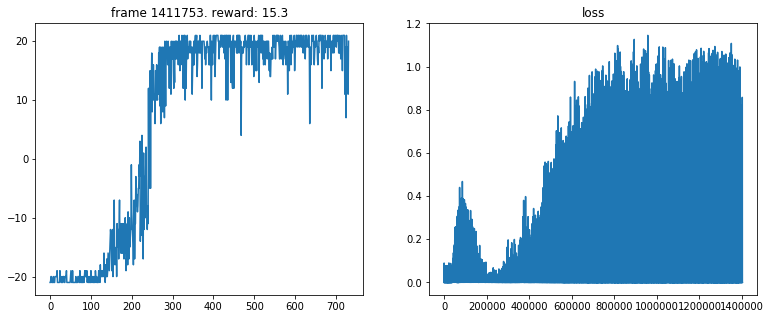

In [9]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)